VIsualization

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10, CIFAR100, ImageNet, Places365
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

from sae import AutoEncoder, sae_loss, get_neuron_freqs, re_initialize
from utils import load_clip, extract_features


/home/smusa28/miniconda3/envs/eecs6322-rpc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models = {
    "resnet50": "RN50",
    "vit_b16": "ViT-B/16",
    "vit_l14": "ViT-L/14"
}

clip_model_name = models["resnet50"]
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [3]:
#//////////////////////////////
clip_model, preprocess = load_clip(clip_model_name, device)

In [4]:
# load autoenocder model from checkpoint
sae = AutoEncoder(device)
checkpoint = torch.load("sae_checkpoints/sae_final.pth", map_location=device)

sae.load_state_dict(checkpoint)
sae.eval()

AutoEncoder()

In [5]:
# load the assigned concept names previously computed
df = pd.read_csv("assigned_concept_names.csv")
concept_names = df["assigned_concepts"].tolist()   # length = sae.latent_dim

In [6]:
# Load the CIFAR‑10 dataset 
cifar10 = CIFAR10(root="./data", train=False, download=True)
images_c10, labels_10 = zip(*cifar10) 

In [6]:
# Load the CIFAR‑100 dataset 
cifar100 = CIFAR100(root="./data", train=False, download=True)
images_c100, labels_100 = zip(*cifar100)

In [ ]:
# ImageNet dataset
imagenet = ImageNet( root="/local/ssd/harryt/datasets/imagenet", split="val" )
# Places365

images_net, labels_net = zip(*imagenet) 

In [7]:
# CLIP FEATURES FOR CIFAR 10
print("Computing CLIP features for CIFAR-100")
all_feats = []
for img in tqdm(images_c100):
    inp = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = clip_model.encode_image(inp)  # [1, D]
    all_feats.append(feat.cpu().squeeze(0))
all_feats = torch.stack(all_feats, dim=0)     # [10000, D]

Computing CLIP features for CIFAR-100


100%|██████████| 10000/10000 [01:31<00:00, 108.74it/s]


In [8]:
# get the sae encoder hidden layer activations
print("Computing SAE hidden activations...")
with torch.no_grad():
    latents = sae.encode(all_feats.to(device)).cpu()  # [10000, latent_dim]

Computing SAE hidden activations...


In [9]:
latents.shape

torch.Size([10000, 8192])

In [19]:
# --- FUNCTION TO PLOT TOP‑K FOR ONE CONCEPT ---

SAVE_DIR = "top_concept_images/cifar_100"
os.makedirs(SAVE_DIR, exist_ok=True)

def plot_topk_for_concept(concept_idx, K=4, save=True):
    scores = latents[:, concept_idx].numpy()      # [10000] the activations for each image at that concept
    topk = np.argsort(scores)[::-1][:K]     # indices of top K, sort them according to top images
    name = concept_names[concept_idx]
    # print("images for concept: ",name)

    fig, axes = plt.subplots(1, K, figsize=(K*2,2))
    # fig.suptitle(f"Concept {concept_idx}: “{name}”", fontsize=12)
    for i, ax in enumerate(axes):
        idx = topk[i]
        ax.imshow(images_c100[idx], interpolation="nearest")
        ax.axis("off")
        # ax.set_title(f"{scores[idx]:.2f}", fontsize=8)

    
    
    if save:
        # make a filesystem‐safe filename
        safe_name = name.replace(" ", "_").replace("/", "_")
        fname = f"concept_{concept_idx}_{safe_name}.png"
        path  = os.path.join(SAVE_DIR, fname)
        fig.savefig(path, dpi=150, bbox_inches="tight")
        print(f"saved to {path}")

    plt.show()
    plt.close(fig)  # close to free memory

    

saved to top_concept_images/cifar_100/concept_4446_turquoise.png


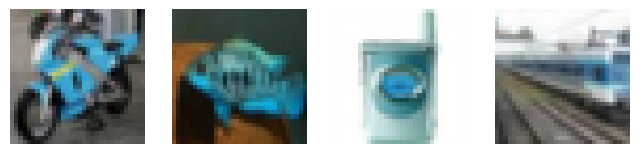

In [20]:
plot_topk_for_concept(4446)

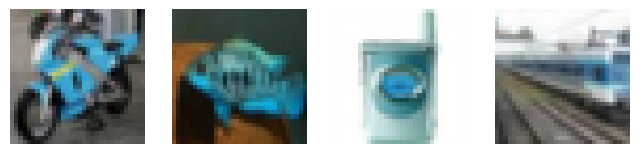

  → saved to top_concept_images/cifar_100/concept_4446_turquoise.png


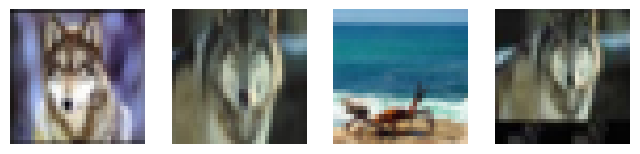

  → saved to top_concept_images/cifar_100/concept_4497_stripes.png


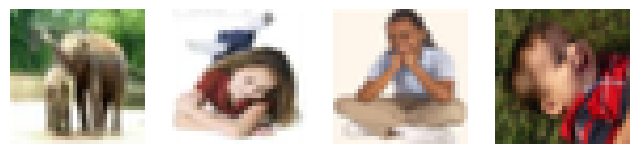

  → saved to top_concept_images/cifar_100/concept_870_asleep.png


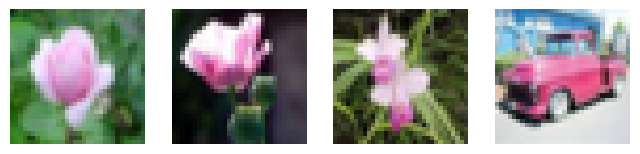

  → saved to top_concept_images/cifar_100/concept_6564_pink.png


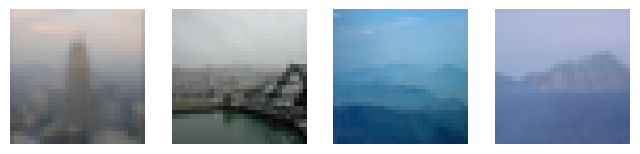

  → saved to top_concept_images/cifar_100/concept_7129_fog.png


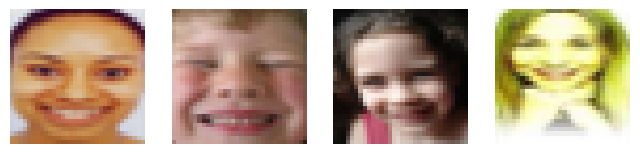

  → saved to top_concept_images/cifar_100/concept_1732_smiling.png


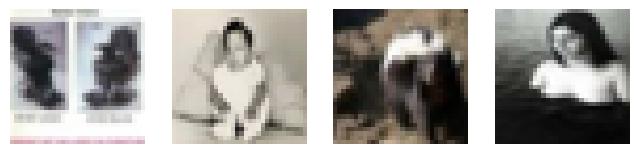

  → saved to top_concept_images/cifar_100/concept_5409_silhouette.png


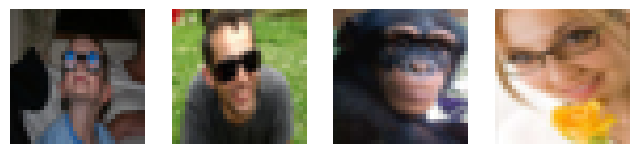

  → saved to top_concept_images/cifar_100/concept_2705_glasses.png


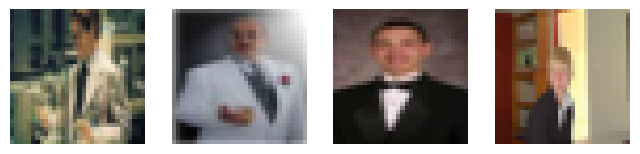

  → saved to top_concept_images/cifar_100/concept_8190_suits.png


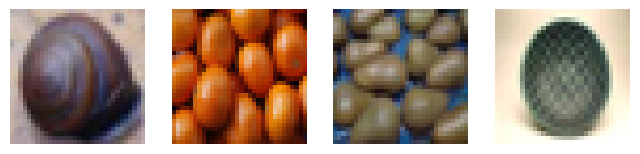

  → saved to top_concept_images/cifar_100/concept_5997_spheres.png


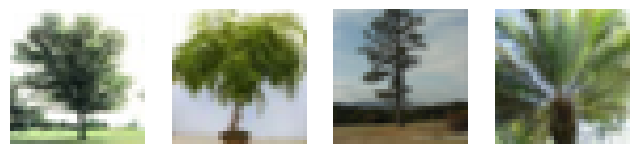

  → saved to top_concept_images/cifar_100/concept_7505_tree.png


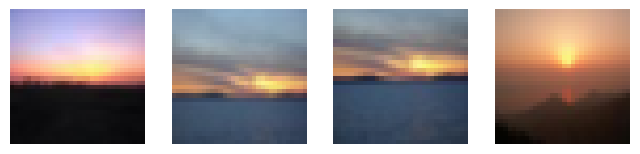

  → saved to top_concept_images/cifar_100/concept_5093_sunset.png


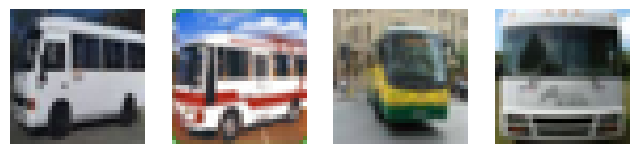

  → saved to top_concept_images/cifar_100/concept_3457_bus.png


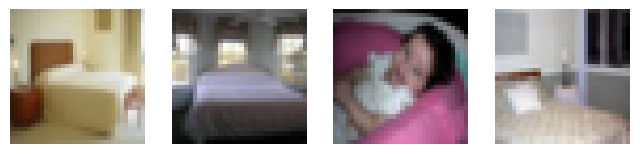

  → saved to top_concept_images/cifar_100/concept_534_bed.png


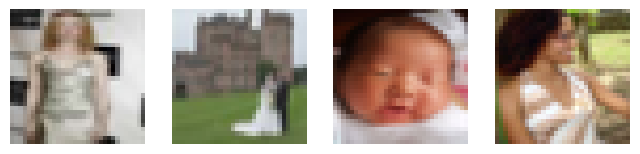

  → saved to top_concept_images/cifar_100/concept_636_brides.png


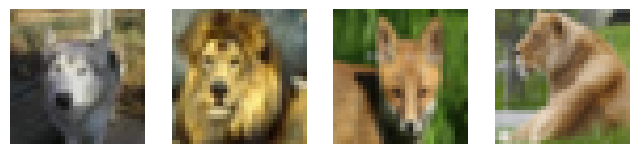

  → saved to top_concept_images/cifar_100/concept_6628_dogs.png


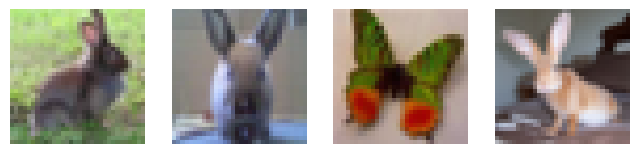

  → saved to top_concept_images/cifar_100/concept_3540_rabbits.png


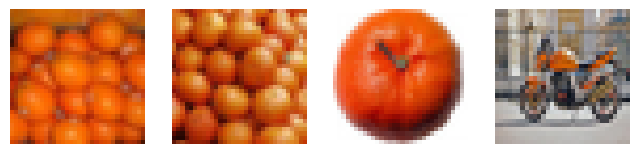

  → saved to top_concept_images/cifar_100/concept_6224_orange.png


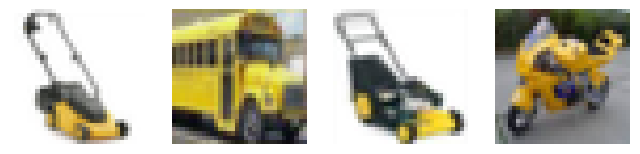

  → saved to top_concept_images/cifar_100/concept_7513_yellow.png


In [15]:
# visualize a few chosen concepts and save
for c in [4446, 4497, 870, 6564, 7129, 1732, 5409, 2705, 8190, 5997, 7505, 5093, 3457, 534, 636, 6628, 3540, 6224, 7513]:  # pick some neuron indices you care about
    plot_topk_for_concept(c)